# Problem Statement

##### - Model ini bertujuan untuk memprediksi apakah seorang nasabah akan gagal membayar pinjaman berdasarkan profil demografis dan finansialnya.
##### - Model ini bisa digunakan oleh tim underwriting fintech/bank untuk membantu proses persetujuan pinjaman.

## Import Library yang digunakan

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

## Load data csv

In [31]:
df = pd.read_csv("..\\data\\german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Hapus kolom id bawaan dataset

In [32]:
df.drop('Unnamed: 0',axis =1,inplace=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Melihat informasi tiap kolom dari dataset

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


#### Dari informasi diatas:
- Terdapat missing value di kolom Saving accounts dan Checking account. Missing value ini akan dihandle nanti
- Terdapat fitur numerikal dan kategorikal dimana perlu di encoding untuk fitur kategorikal termasuk label "Risk" 

### Melihat stastik deskriptif dari dataset

In [34]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


- Fitur credit amount memiliki rata rata dan median yang menandakan distribusi data yang kurang seimbang
- Range antara data credit amount yang paling kecil dan data yang paling besar cukup besar yang menandakan kemungkinan adanya outlier ataupun handling dengan transform log

#### Fungsi untuk membantu dalam EDA dan visualisasi

In [35]:
def hist_box_plot(data, target=None, title='', xlabel='', ylabel=''):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    if target is not None:
        unique_labels = np.unique(target)
        for label in unique_labels:
            plt.hist(data[target == label], alpha=0.5, label=f'Target {label}')
        plt.legend()
    else:
        plt.hist(data)
    plt.title(f'{title} - Histogram')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Boxplot
    plt.subplot(1, 2, 2)
    if target is not None:
        sns.boxplot(x=target, y=data)
    else:
        sns.boxplot(x=data)
    plt.title(f'{title} - Boxplot')
    plt.xlabel('Target' if target is not None else xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()

def bar_plot(data, target=None, title='', xlabel='', ylabel='', proportional=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    plt.figure(figsize=(6, 4))

    if target is not None:
        temp_df = pd.DataFrame({'feature': data, 'target': target})

        if proportional:
            ctab = pd.crosstab(temp_df['feature'], temp_df['target'], normalize='index')
            ax = ctab.plot(kind='bar', stacked=True, colormap='coolwarm', width=0.8)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Proportion')
            plt.xticks(rotation=30)

            for i, cat in enumerate(ctab.index):
                bottom = 0
                for j, cls in enumerate(ctab.columns):
                    pct = ctab.loc[cat, cls]
                    if pct > 0.01:
                        ax.text(
                            x=i,
                            y=bottom + pct / 2,
                            s=f"{pct*100:.1f}%",
                            ha='center',
                            va='center',
                            fontsize=9,
                            color='white' if pct > 0.25 else 'black'
                        )
                    bottom += pct
        else:
            sns.countplot(x='feature', hue='target', data=temp_df)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Count')
            plt.xticks(rotation=30)
            plt.tight_layout()
            plt.show()

    else:
        counts = data.value_counts()
        plt.bar(counts.index, counts.values)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel('Count')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()


def heatmap(data, title=""):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.heatmap(data, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def cramers_v(x, y):
    import pandas as pd
    import numpy as np
    from scipy.stats import chi2_contingency

    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))


def cramers_v_matrix(df):
    import pandas as pd
    cat_cols = df.select_dtypes(include='object').columns
    result = pd.DataFrame(index=cat_cols, columns=cat_cols)

    for col1 in cat_cols:
        for col2 in cat_cols:
            result.loc[col1, col2] = cramers_v(df[col1], df[col2])

    return result.astype(float)

### Visualisasi fitur Target "Risk"

Risk
good    0.7
bad     0.3
Name: proportion, dtype: float64


<Axes: xlabel='count', ylabel='Risk'>

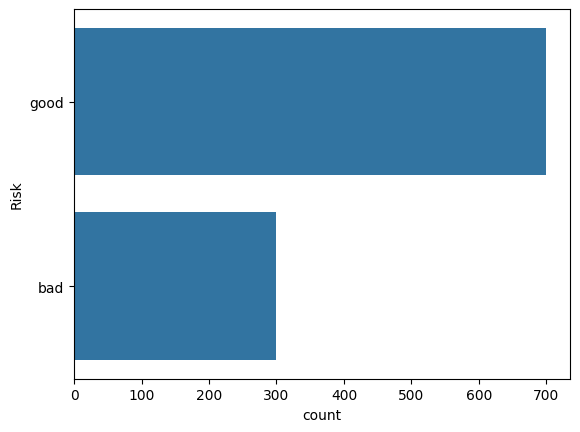

In [36]:
print(df['Risk'].value_counts(normalize=True))
sns.countplot(df['Risk'])

- Dataset imbalanced dimana sekitar 70% dari data memiliki label good
- Ini menunjukkan perlunya metriks evaluasi yang sesuai nantinya ketika modelling

### Visualisasi analisis univariate antara fitur Age dan label Risk

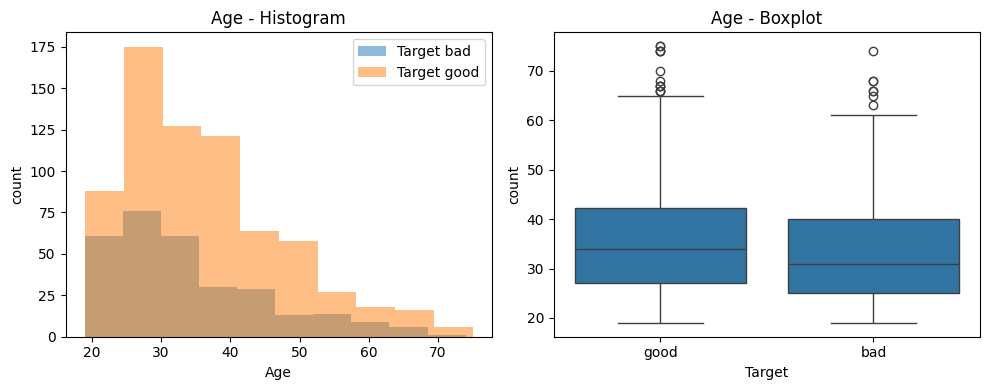

In [37]:
hist_box_plot(df['Age'],title='Age',xlabel='Age',ylabel='count',target= df['Risk'])

- Distribusi data keseluruhan mirip
- Data good dominan di seluruh range umur dikarenakan dataset imbalanced
- Proporsi bad lebih besar di usia muda
- Perlu dilakukan binning umur untuk melihat perbandingan proporsi yang lebih baik 

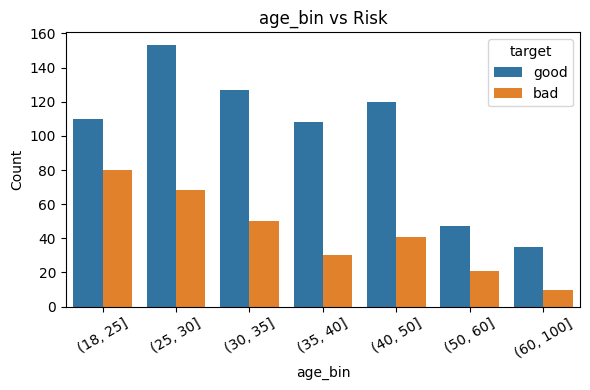

<Figure size 600x400 with 0 Axes>

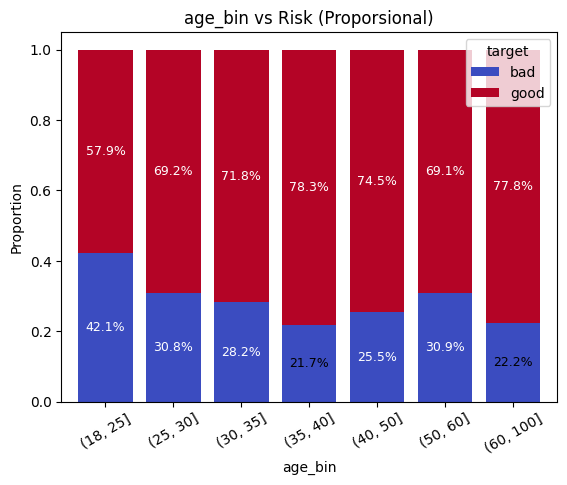

In [38]:
df['age_bin'] = pd.cut(df['Age'], bins=[18,25,30,35,40,50,60,100])
bar_plot(df['age_bin'],title='age_bin vs Risk',xlabel='age_bin',ylabel='Count', target=df['Risk'])
bar_plot(df['age_bin'],title='age_bin vs Risk (Proporsional)',xlabel='age_bin',ylabel='Count', target=df['Risk'],proportional=True)


- Proporsi nasabah berisiko bad paling tinggi berada di rentang usia 18-25 tahun, yang kemudian cenderung menurun seiring bertambahnya usia. Ini menunjukkan korelasi negatif antara Age dan Risk.
- Ini mungkin berarti karena nasabah usia muda belum memiliki penghasilan yang tetap ataupun kemampuan mengelola finansial yang belum baik sehingga meningkatkan resiko gagal bayar
- Informasi ini juga memberi tau kalau proporsi nasabah yang berisiko bad paling tinggi berada di rentang usia muda, yang bisa menjadi indikasi untuk perlu memberi semacam persetujuan tambahan calon nasabah di rentang umur 18-25 tahun untuk meminimalisir gagal bayar.

### Fitur Sex

Sex
male      690
female    310
Name: count, dtype: int64


<Figure size 600x400 with 0 Axes>

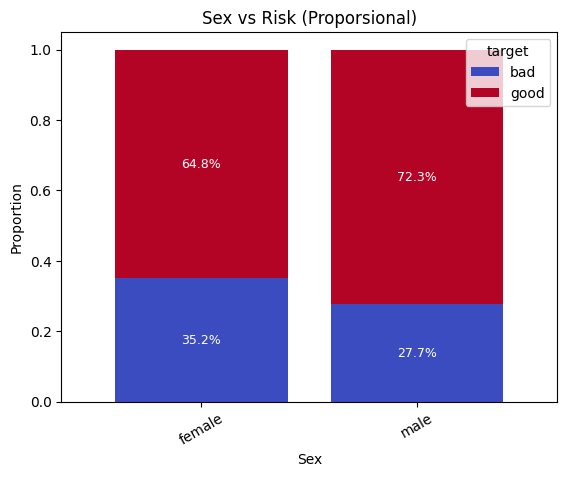

In [39]:
print(df['Sex'].value_counts())
bar_plot(df['Sex'],title='Sex vs Risk (Proporsional)',xlabel='Sex',ylabel='Count', target=df['Risk'],proportional=True)

- Visualisasi proporsi menunjukkan kalau nasabah pria memiliki risiko gagal bayar yang sedikit lebih tinggi (72.3%) dibanding nasabah wanita (64.8%). 
- Meskipun perbedaan tidak terlalu ekstrim, hal ini tetap relevan 

### Fitur job

Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64


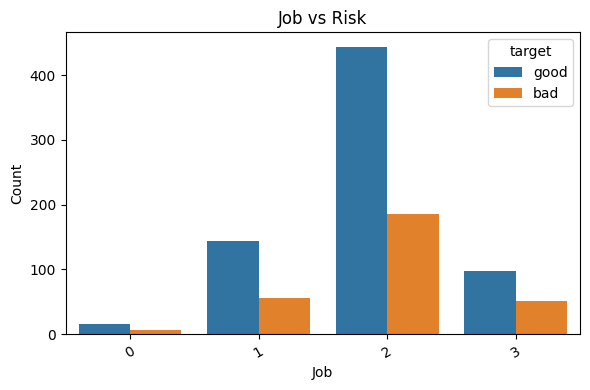

<Figure size 600x400 with 0 Axes>

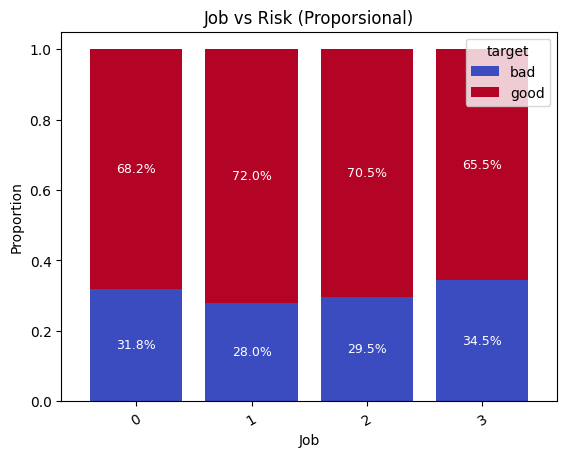

In [40]:
print(df['Job'].value_counts())
bar_plot(df['Job'],title='Job vs Risk',xlabel='Job',ylabel='Count', target=df['Risk'])
bar_plot(df['Job'],title='Job vs Risk (Proporsional)',xlabel='Job',ylabel='Count', target=df['Risk'],proportional=True)

- Distribusi kategori pekerjaan tidak seimbang, dimana mayoritas merupakan Job = 2
- Dari visualisasi proporsi, proporsi gagal bayar cukup tinggi untuk semua jenis pekerjaan
- Job 1 memiliki persentase gagal bayar tertinggi (72%), yang bisa menjadi sinyal bahwa kelompok pekerjaan ini mungkin memiliki tingkat kestabilan pendapatan yang lebih rendah dibanding yang lain.
- Ini bisa menjadi indikasi untuk memberi perhatian khusus pada nasabah dengan pekerjaan jenis tersebut

### Fitur housing

Housing
own     713
rent    179
free    108
Name: count, dtype: int64


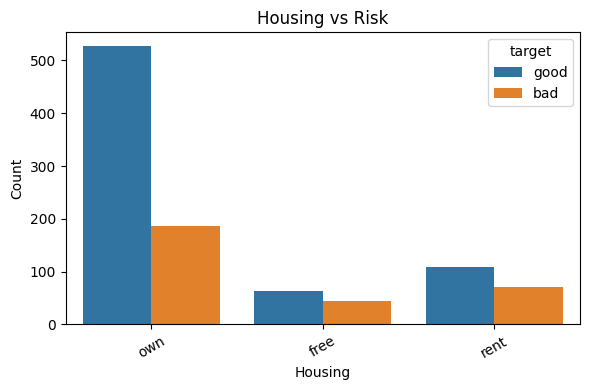

<Figure size 600x400 with 0 Axes>

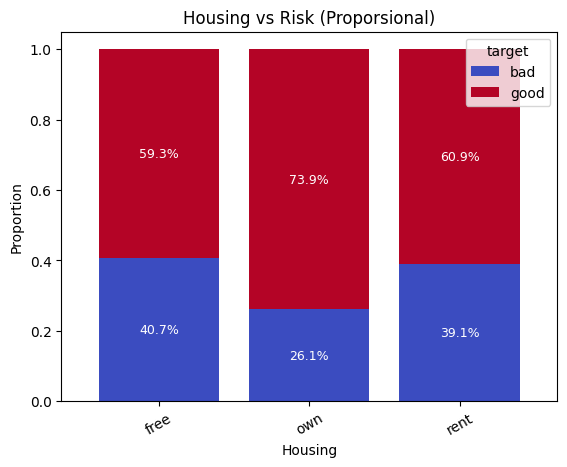

In [41]:
print(df['Housing'].value_counts())
bar_plot(df['Housing'],title='Housing vs Risk',xlabel='Housing',ylabel='Count', target=df['Risk'])
bar_plot(df['Housing'],title='Housing vs Risk (Proporsional)',xlabel='Housing',ylabel='Count', target=df['Risk'],proportional=True)

- Distribusi kategori cukup tidak seimbang dimana mayoritas merupakan Housing = free. 
- Dari hasil visualisasi proporsi, terdapat kontra intuitif dimana nasabah yang memiliki rumah justru memiliki persentase gagal bayar yang tertinggi. Dari sini, status kepemilikan rumah tidak bisa dijadikan acuan tunggal untuk mengukur risiko dan harus digabungkan dengan fitur lain
- Ini juga bisa berarti kalau nasabah yang memiliki rumah mungkin memiliki tanggungan/cicilan lain yang menyebabkan kurangnya kemampuan membayar

### Fitur Saving accounts

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64


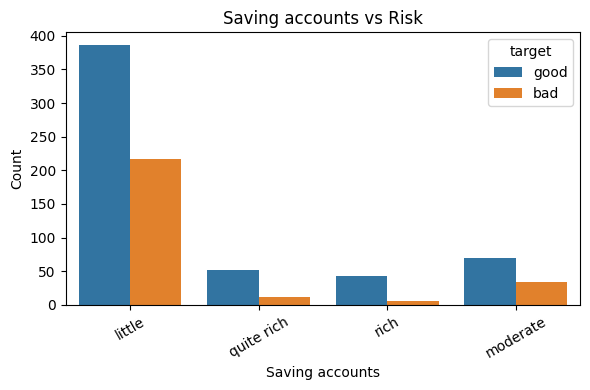

<Figure size 600x400 with 0 Axes>

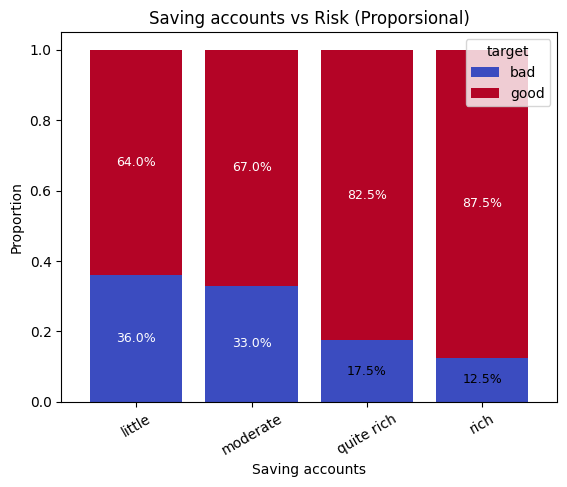

In [42]:
print(df['Saving accounts'].value_counts())
bar_plot(df['Saving accounts'],title='Saving accounts vs Risk',xlabel='Saving accounts',ylabel='Count', target=df['Risk'])
bar_plot(df['Saving accounts'],title='Saving accounts vs Risk (Proporsional)',xlabel='Saving accounts',ylabel='Count', target=df['Risk'],proportional=True)

- Terdapat hubungan yang kuat antara tingkat Tabungan terhadap risiko gagal bayar. Nasabah dengan tingkat tabungan tinggi memiliki kemungkinan gagal bayar yang jauh lebih rendah (17.5% dan 12.5%)
- Ini menunjukkan saving accounts adalah salah satu indikator kuat untuk stabilitas finansial dan kemampuan bayar 
- Ini menjadi indikasi untuk memberi perhatian atau persetujuan lebih lanjut untuk calon nasabah dengan tingkat tabungan rendah

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64


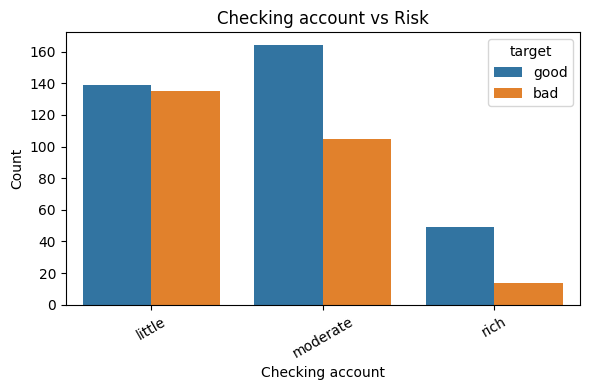

<Figure size 600x400 with 0 Axes>

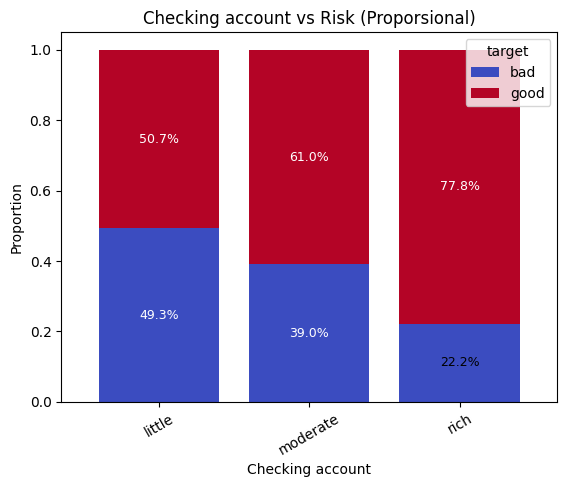

In [43]:
print(df['Checking account'].value_counts())
bar_plot(df['Checking account'],title='Checking account vs Risk',xlabel='Checking account',ylabel='Count', target=df['Risk'])
bar_plot(df['Checking account'],title='Checking account vs Risk (Proporsional)',xlabel='Checking account',ylabel='Count', target=df['Risk'],proportional=True)

- Terdapat hubungan yang kuat juga antara Checking account terhadap risiko gagal bayar. Nasabah dengan tingkat saldo rekening giro tinggi memiliki kemungkinan gagal bayar yang lebih rendah (22.2%)
- Walau tidak setajam Saving accounts, fitur ini tetap jadi salah satu indikator kuat untuk kemampuan bayar 
- Ini juga menjadi indikator untuk memberi perhatian atau persetujuan lebih untuk calon nasabah dengan tingkat saldo rekening giro rendah.

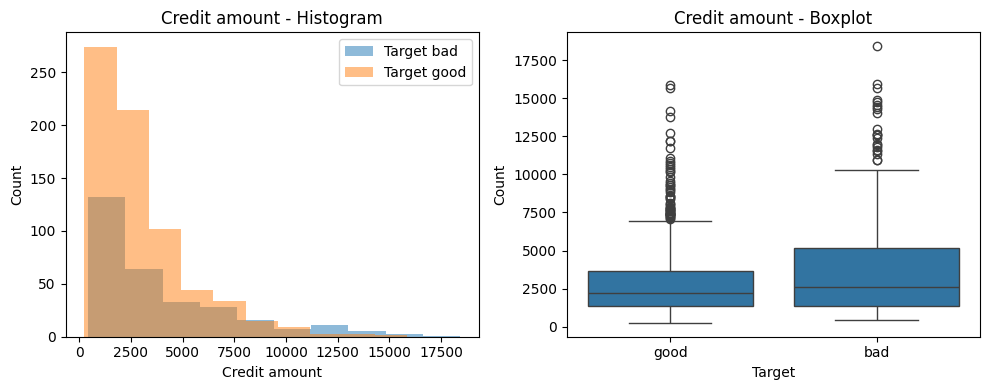

In [44]:
hist_box_plot(df['Credit amount'],title='Credit amount',xlabel='Credit amount',ylabel='Count',target=df['Risk'])

- Fitur credit amount sangat right skewed dimana mayoritas jumlah pinjaman nasabah < 5000. 
- Terdapat outlier ekstrem sampai 17000+ yang menunjukkan variasi besar dalam jumlah pinjaman antar nasabah
- Untuk analisis atau modeling, perlu dilakukan binning ataupun log transform agar distribusi lebih stabil

credit_bin
very low    432
low         380
mid         148
high         40
Name: count, dtype: int64


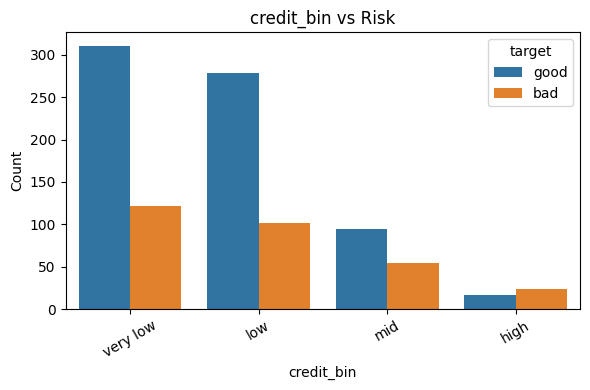

<Figure size 600x400 with 0 Axes>

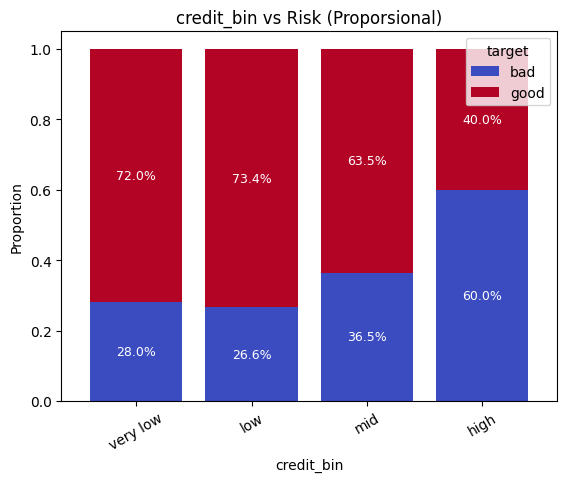

In [45]:
df['credit_bin'] = pd.cut(df['Credit amount'], bins=[0, 2000, 5000, 10000, 20000], labels=['very low', 'low', 'mid', 'high'])
print(df['credit_bin'].value_counts())
bar_plot(df['credit_bin'],title='credit_bin vs Risk',xlabel='credit_bin',ylabel='Count', target=df['Risk'])
bar_plot(df['credit_bin'],title='credit_bin vs Risk (Proporsional)',xlabel='credit_bin',ylabel='Count', target=df['Risk'],proportional=True)

- Dari visualisasi proporsi, bisa dilihat bahwa mayoritas gagal bayar justru terdapat pada kelompok peminjam menengah dan besar. 
- Nasabah dengan pinjaman > 10000 memiliki risiko gagal bayar 2 kali lipat lebih tinggi dibanding nasabah dengan pinjaman < 5000.
- Sebaliknya, nasabah dengan pinjaman kecil memiliki tingkat gagal bayar yang lebih rendah
- Ini menjadi indikator kalau perlu memberi perhatian lebih pada nasabah dengan pinjaman besar misalnya dengan meminta semacam jaminan lebih ketika meminjam.

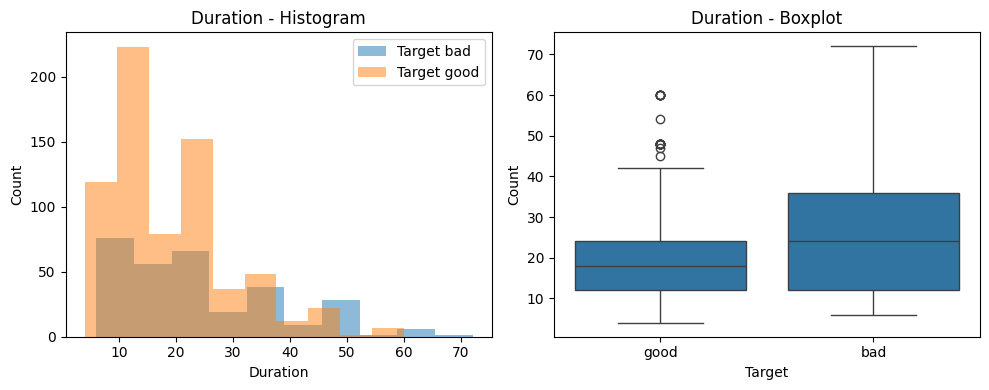

In [46]:
hist_box_plot(df['Duration'],title='Duration',xlabel='Duration',ylabel='Count',target=df['Risk'])

duration_bin
13-24    411
<=12     359
25–36    143
37–48     71
>48       16
Name: count, dtype: int64


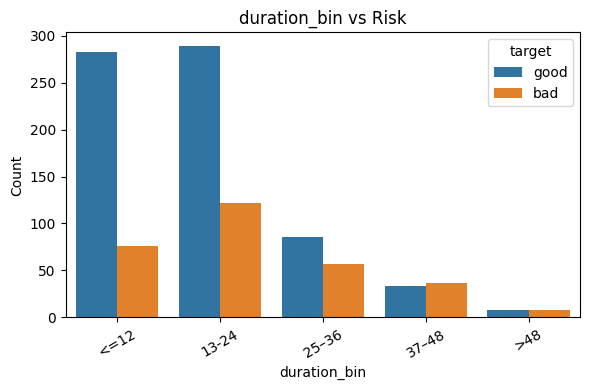

<Figure size 600x400 with 0 Axes>

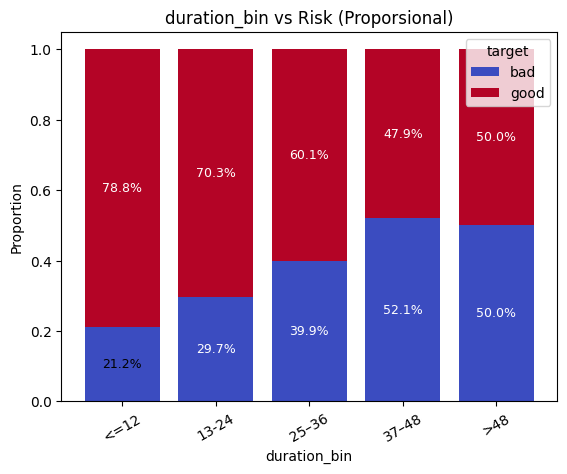

In [47]:
df['duration_bin'] = pd.cut(df['Duration'], bins=[0, 12, 24, 36, 48, 100], labels=['<=12', '13-24', '25–36', '37–48', '>48'])

print(df['duration_bin'].value_counts())
bar_plot(df['duration_bin'],title='duration_bin vs Risk',xlabel='duration_bin',ylabel='Count', target=df['Risk'])
bar_plot(df['duration_bin'],title='duration_bin vs Risk (Proporsional)',xlabel='duration_bin',ylabel='Count', target=df['Risk'],proportional=True)

- Visualisasi proporsional untuk durasi pinjaman menunjukkan hubungan kuat antara lama pinjaman dan risiko gagal bayar, dimana semakin meningkat durasi pinjaman, cenderung semakin tinggi untuk risiko gagal bayar.
- Ini juga menjadi indikator untuk memberi perhatian lebih pada nasabah jika durasi pinjaman cukup lama

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64


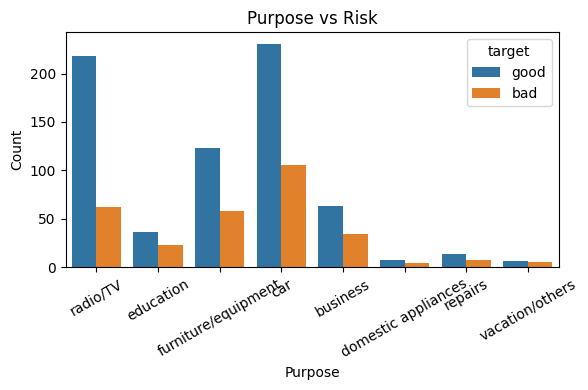

<Figure size 600x400 with 0 Axes>

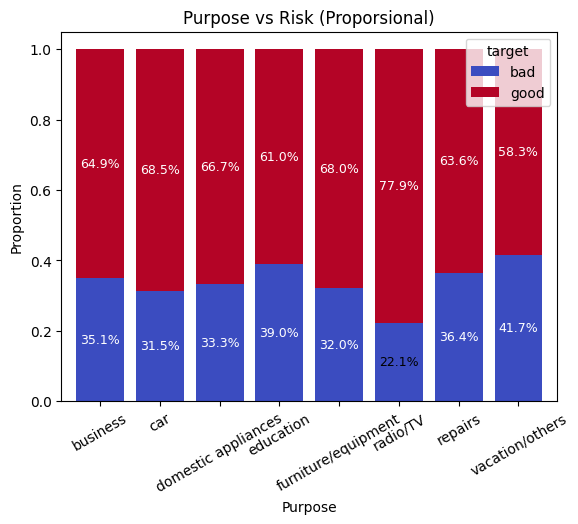

In [48]:
print(df['Purpose'].value_counts())
bar_plot(df['Purpose'],title='Purpose vs Risk',xlabel='Purpose',ylabel='Count', target=df['Risk'])
bar_plot(df['Purpose'],title='Purpose vs Risk (Proporsional)',xlabel='Purpose',ylabel='Count', target=df['Risk'],proportional=True)

- Visualisasi distribusi menunjukkan matoritas tujuan nasabah meminjam adalah untuk membeli mobil ataupun radio/TV.
- Dari visualisasi proporsi, terlihat bahwa nasabah yang bertujuan membeli radio/TV berdasarkan pinjaman memiliki tingkat gagal bayar yang paling rendah dari semua kategori, sementara nasabah yang bertujuan untuk vacation atau yang lainnya, memiliki tingkat gagal bayar paling tinggi.
- Ini bisa menjadi acuan atau indikator untuk memberi perhatian lebih pada calon nasabah dengan tujuan meminjam untuk vacation

### Korelasi antar fitur numerik dataset

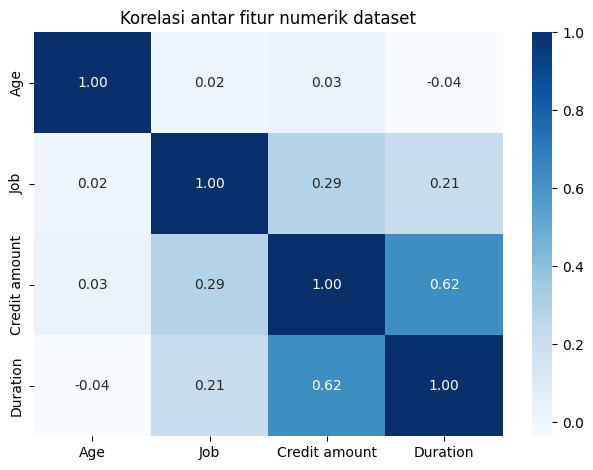

In [49]:
heatmap(df.corr(numeric_only=True),title="Korelasi antar fitur numerik dataset")

Heatmap korelasi ini menunjukkan Korelasi antar fitur numerik dalam dataset. Credti amount dan Duration memiliki Korelasi sebesar 0.62 yang menunjukkan hubungan lumayan kuat. Dimana bisa disimpulkan disini kalau semakin tinggi credit amount, durasi pembayaran oleh nasabah juga meningkat

### Korelasi antar fitur kategorikal dataset

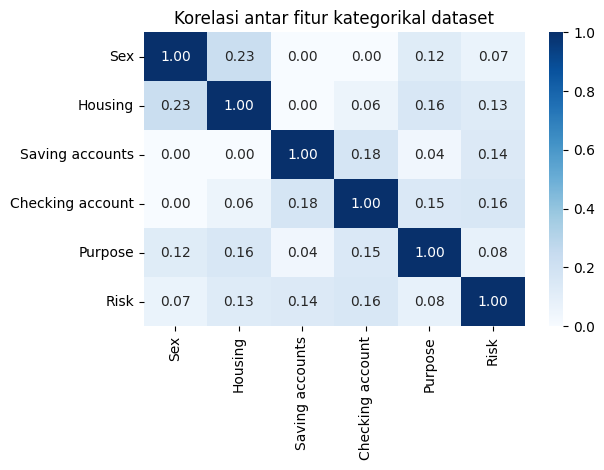

In [50]:
heatmap(cramers_v_matrix(df),title="Korelasi antar fitur kategorikal dataset")

Heatmap korelasi ini menunjukkan Korelasi antar fitur kategorikal dalam dataset. Terlihat kalau Korelasi antar fitur keseluruhan tidak adanya hubungan yang kuat antar fitur yang menunjukkan tidak adanya fitur yang redundan dalam dataset. Kedepannya mungkin perlu dilakukan Feature interaction untuk mengetahui hubungan antar fitur yang lebih kompleks.

### Handling missing data

- Untuk missing value pada fitur Saving account dan Checking account, karena terdapat cukup banyak, maka dilakukan dengan membuat kategori baru yaitu "Unknown". 
- Hal ini dikarenakan fitur fitur tadi cukup skewed dan perlu untu diseimbangkan dengan kategori baru.
- Saya juga tetap mempertimbangkan untuk menghandle missing data dengan imputasi berdasarkan mode dari tiap fitur data dimana akan dilakukan AB Testing nantinya.

In [51]:
df['Saving accounts']= df['Saving accounts'].fillna("Unknown")
df['Checking account']= df['Checking account'].fillna("Unknown")

In [52]:
df_clean = df.fillna(df.mode().iloc[0])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 non-null   object  
 2   Job               1000 non-null   int64   
 3   Housing           1000 non-null   object  
 4   Saving accounts   1000 non-null   object  
 5   Checking account  1000 non-null   object  
 6   Credit amount     1000 non-null   int64   
 7   Duration          1000 non-null   int64   
 8   Purpose           1000 non-null   object  
 9   Risk              1000 non-null   object  
 10  age_bin           1000 non-null   category
 11  credit_bin        1000 non-null   category
 12  duration_bin      1000 non-null   category
dtypes: category(3), int64(4), object(6)
memory usage: 82.0+ KB


### Mapping label Risk untuk modelling

In [53]:
df_clean['Risk'] = df_clean['Risk'].map({'good':0,'bad':1})
df_clean.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,age_bin,credit_bin,duration_bin
0,67,male,2,own,Unknown,little,1169,6,radio/TV,0,"(60, 100]",very low,<=12
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,"(18, 25]",mid,37–48
2,49,male,1,own,little,Unknown,2096,12,education,0,"(40, 50]",low,<=12
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,"(40, 50]",mid,37–48
4,53,male,2,free,little,little,4870,24,car,1,"(50, 60]",low,13-24


In [54]:
df_clean.to_csv("..\\data\\german_credit_data_clean.csv",index=False)